In [ ]:
!pip install sklearn

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import torch.utils.model_zoo as model_zoo

import easydict
import cv2

import os
from glob import glob
import pickle
import random
import math

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Binarizer

In [2]:
os.listdir('64x64')

['.ipynb_checkpoints',
 'model',
 'test.csv',
 'test_binary.pkl',
 'train.csv',
 'train.pkl',
 'train_binary.pkl',
 'val.csv',
 'val_binary.pkl']

In [3]:
# class2idx
class2idx = {'구이/갈비구이': 0, '구이/갈치구이': 1, '구이/고등어구이': 2, '구이/곱창구이': 3, '구이/닭갈비': 4, '구이/더덕구이': 5, '구이/떡갈비': 6, '구이/불고기': 7, '구이/삼겹살': 8, '구이/장어구이': 9, '구이/조개구이': 10, '구이/조기구이': 11, '구이/황태구이': 12, '구이/훈제오리': 13, '국/계란국': 14, '국/떡국_만두국': 15, '국/무국': 16, '국/미역국': 17, '국/북엇국': 18, '국/시래기국': 19, '국/육개장': 20, '국/콩나물국': 21, '기타/과메기': 22, '기타/양념치킨': 23, '기타/젓갈': 24, '기타/콩자반': 25, '기타/편육': 26, '기타/피자': 27, '기타/후라이드치킨': 28, '김치/갓김치': 29, '김치/깍두기': 30, '김치/나박김치': 31, '김치/무생채': 32, '김치/배추김치': 33, '김치/백김치': 34, '김치/부추김치': 35, '김치/열무김치': 36, '김치/오이소박이': 37, '김치/총각김치': 38, '김치/파김치': 39, '나물/가지볶음': 40, '나물/고사리나물': 41, '나물/미역줄기볶음': 42, '나물/숙주나물': 43, '나물/시금치나물': 44, '나물/애호박볶음': 45, '떡/경단': 46, '떡/꿀떡': 47, '떡/송편': 48, '만두/만두': 49, '면/라면': 50, '면/막국수': 51, '면/물냉면': 52, '면/비빔냉면': 53, '면/수제비': 54, '면/열무국수': 55, '면/잔치국수': 56, '면/짜장면': 57, '면/짬뽕': 58, '면/쫄면': 59, '면/칼국수': 60, '면/콩국수': 61, '무침/꽈리고추무침': 62, '무침/도라지무침': 63, '무침/도토리묵': 64, '무침/잡채': 65, '무침/콩나물무침': 66, '무침/홍어무침': 67, '무침/회무침': 68, '밥/김밥': 69, '밥/김치볶음밥': 70, '밥/누룽지': 71, '밥/비빔밥': 72, '밥/새우볶음밥': 73, '밥/알밥': 74, '밥/유부초밥': 75, '밥/잡곡밥': 76, '밥/주먹밥': 77, '볶음/감자채볶음': 78, '볶음/건새우볶음': 79, '볶음/고추장진미채볶음': 80, '볶음/두부김치': 81, '볶음/떡볶이': 82, '볶음/라볶이': 83, '볶음/멸치볶음': 84, '볶음/소세지볶음': 85, '볶음/어묵볶음': 86, '볶음/오징어채볶음': 87, '볶음/제육볶음': 88, '볶음/주꾸미볶음': 89, '쌈/보쌈': 90, '음청류/수정과': 91, '음청류/식혜': 92, '장/간장게장': 93, '장/양념게장': 94, '장아찌/깻잎장아찌': 95, '적/떡꼬치': 96, '전/감자전': 97, '전/계란말이': 98, '전/계란후라이': 99, '전/김치전': 100, '전/동그랑땡': 101, '전/생선전': 102, '전/파전': 103, '전/호박전': 104, '전골/곱창전골': 105, '조림/갈치조림': 106, '조림/감자조림': 107, '조림/고등어조림': 108, '조림/꽁치조림': 109, '조림/두부조림': 110, '조림/땅콩조림': 111, '조림/메추리알장조림': 112, '조림/연근조림': 113, '조림/우엉조림': 114, '조림/장조림': 115, '조림/코다리조림': 116, '죽/전복죽': 117, '죽/호박죽': 118, '찌개/김치찌개': 119, '찌개/닭계장': 120, '찌개/동태찌개': 121, '찌개/된장찌개': 122, '찌개/순두부찌개': 123, '찜/갈비찜': 124, '찜/계란찜': 125, '찜/김치찜': 126, '찜/꼬막찜': 127, '찜/닭볶음탕': 128, '찜/수육': 129, '찜/순대': 130, '찜/족발': 131, '찜/찜닭': 132, '찜/해물찜': 133, '탕/갈비탕': 134, '탕/감자탕': 135, '탕/곰탕_설렁탕': 136, '탕/매운탕': 137, '탕/삼계탕': 138, '탕/추어탕': 139, '튀김/고추튀김': 140, '튀김/새우튀김': 141, '튀김/오징어튀김': 142, '한과/약과': 143, '한과/약식': 144, '한과/한과': 145, '해물/멍게': 146, '해물/산낙지': 147, '회/물회': 148, '회/육회': 149}

In [4]:
# model
class CNN(nn.Module):
    def __init__(self, n_class=150):
        super(CNN, self).__init__()
        # (64,64,1) => (32,32,16) => (16,16,16) => (8,8,32) => (4,4,64)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=6, stride=2, padding=2),
            nn.Dropout(),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=6, stride=2, padding=2),
            nn.Dropout(),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=6, stride=2, padding=2),
            nn.Dropout(),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1))
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=6, stride=2, padding=2),
            nn.Dropout(),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1))
        self.fc = nn.Linear(1024, 150)

    def forward(self, x):
        #print(1, x.shape)
        out = self.layer1(x.unsqueeze(1))
        #print(2, out.shape)
        out = self.layer2(out)
        #print(3, out.shape)
        out = self.layer3(out)
        #print(4, out.shape)
        out = self.layer4(out)
        #print(5, out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, in_channels=1):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=7, stride=1, padding=3,
                               bias=False) # ori : stride = 2
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [10]:
class background_resnet(nn.Module):
    def __init__(self, embedding_size, num_classes, backbone='resnet18'):
        super(background_resnet, self).__init__()
        self.backbone = backbone
        # copying modules from pretrained models
        if backbone == 'resnet50':
            self.pretrained = resnet50(pretrained=False)
        elif backbone == 'resnet101':
            self.pretrained = resnet101(pretrained=False)
        elif backbone == 'resnet152':
            self.pretrained = resnet152(pretrained=False)
        elif backbone == 'resnet18':
            self.pretrained = resnet18(pretrained=False)
        elif backbone == 'resnet34':
            self.pretrained = resnet34(pretrained=False)
        else:
            raise RuntimeError('unknown backbone: {}'.format(backbone))
            
        self.fc0 = nn.Linear(128, embedding_size)
        self.bn0 = nn.BatchNorm1d(embedding_size)
        self.relu = nn.ReLU()
        self.last = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # input x: minibatch x 1 x 40 x 40
        x = self.pretrained.conv1(x.unsqueeze(1))
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        
        x = self.pretrained.layer1(x)
        x = self.pretrained.layer2(x)
        x = self.pretrained.layer3(x)
        x = self.pretrained.layer4(x)
        
        out = F.adaptive_avg_pool2d(x,1) # [batch, 128, 1, 1]
        out = torch.squeeze(out) # [batch, n_embed]
        # flatten the out so that the fully connected layer can be connected from here
        out = out.view(x.size(0), -1) # (n_batch, n_embed)
        spk_embedding = self.fc0(out)
        out = F.relu(self.bn0(spk_embedding)) # [batch, n_embed]
        out = self.last(out)
        
        return out

In [11]:
# trainer
class Trainer():
    def __init__(self, args):
        self.args = args
        self.loader = IMG_Loader(args)
        #self.model = CNN(args)
        self.model = background_resnet(embedding_size=256, num_classes=150)
        if self.args.device == 'cuda':
          self.model.cuda()

        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.model.parameters())
        
    def train(self):
        # train
        total_step = len(self.loader.data_loader)
        val_loader = IMG_Loader(self.args, is_validated=True)
        opt_epoch = 1
        min_val_loss = 1e9

        print(total_step)
        for epoch in range(self.args.epoch):
            self.model.train()
            total_loss = 0

            for i in range(len(self.loader.data_loader)):
                feature, label = self.loader.next_batch()
                feature = torch.tensor(feature).to(device=self.args.device, dtype=torch.float)
                label = torch.tensor(label).to(device=self.args.device)

                pred = self.model(feature)
                loss = self.criterion(pred, label)

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                total_loss += loss.item()
                if (i + 1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, self.args.epoch, i + 1, total_step, loss.item()))

            if (epoch+1)%50 == 0:
                val_loss = self.validate(val_loader)
                print ('Validation Loss: {:.20f}'.format(val_loss))
                if val_loss < min_val_loss:
                  val_loss = min_val_loss
                  opt_epoch = epoch+1
   
            torch.save(self.model.state_dict(), '64x64\\model\\checkpoint2_'+str(epoch+1)+'.pt')

    def validate(self, val_loader):
        total_loss = 0
        total_step = len(val_loader.data_loader)

        self.model.eval()
        with torch.no_grad():
            for i in range(len(val_loader.data_loader)):
                feature, label = val_loader.next_batch()
                feature = torch.tensor(feature).to(device=self.args.device, dtype=torch.float)
                label = torch.tensor(label).to(device=self.args.device)

                pred = self.model(feature)
                loss = self.criterion(pred, label)
                total_loss += loss.item()

                if (i + 1) % 1000 == 0:
                    print ('Validation Step [{}/{}], Loss: {:.4f}'.format(i + 1, total_step, loss.item()))

        return total_loss/total_step


    def test(self):
        # test
        #self.model.load_state_dict(torch.load(self.args.ckpt))
        self.model.load_state_dict(torch.load('64x64\\model\\checkpoint_8.pt', map_location=torch.device('cpu')))
        self.model.eval()

        pred_list = list()
        label_list = list()

        with torch.no_grad():
            for i in range(len(self.loader.data_loader)):
                feature, label = self.loader.next_batch()
                feature = torch.tensor(feature).to(device=self.args.device, dtype=torch.float)
                label = torch.tensor(label).to(device=self.args.device)

                pred = self.model(feature)
                pred = F.softmax(pred, dim=1)
                pred = torch.argmax(pred, dim=1)
                
                pred_list.extend(pred.tolist())
                label_list.extend(label.tolist())

        acc = accuracy_score(label_list, pred_list)
        print(acc)

In [12]:
# dataloader
class IMG_Dataset(Dataset):
    def __init__(self, args, is_validated=False):
        self.args = args
        if is_validated == True:
          self.args.mode = 'val'

        data_path = os.path.join('64x64', args.mode+'_binary') + '.pkl'

        if os.path.isfile(data_path):
            with open(data_path, 'rb') as f:
                self.data = pickle.load(f)
        else:
            df = pd.read_csv(os.path.join('64x64', args.mode) + '.csv', names=range(0,4097))

            self.data = []

            y = df[0]
            x = df.drop(labels=[0], axis=1)
            x = normalize(x, axis=0)
            x = x.reshape(-1,1,64,64)

            for i in range(len(y)):
                self.data.append((x[i], y[i]))
                if(i % 1000 == 0):
                    print(i)
            print(len(self.data))
            with open(data_path, 'wb') as f:
                pickle.dump(self.data, f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


class IMG_Loader(object):
    def __init__(self, args, is_validated=False):
        super().__init__()

        dataset = IMG_Dataset(args)

        if args.mode == 'train':
            self.data_loader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
        else:
            self.data_loader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size)
        
        self.data_iter = self.data_loader.__iter__()
    
    def next_batch(self):
        try:
            batch = self.data_iter.__next__()
        except StopIteration:
            self.data_iter = self.data_loader.__iter__()
            batch = self.data_iter.__next__()
        
        return batch

In [13]:
# args
def get_args():
    args = easydict.EasyDict({
        "epoch": 100,
        "batch_size": 32,
        "mode": 'train',
        "ckpt": 1,
        "device": 'cuda'
    })
    return args

def get_args2() :
  args = EasyDict({
      "mode":'test',
      "batch_size":1,
      "ckpt":'64x64\\model\\checkpoint_final.pt',
      "device":'cuda',
      "n_class":150,
  })
  return args

In [ ]:
# model run
args = get_args()
trainer = Trainer(args)

if args.mode == 'train':
  trainer.train()
else:
  trainer.test()

2266


C:\Users\82108\AppData\Local\Temp/ipykernel_2480/533309440.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(feature).to(device=self.args.device, dtype=torch.float)
C:\Users\82108\AppData\Local\Temp/ipykernel_2480/533309440.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device=self.args.device)


Epoch [1/100], Step [100/2266], Loss: 4.7666
Epoch [1/100], Step [200/2266], Loss: 4.7768
Epoch [1/100], Step [300/2266], Loss: 4.7121
Epoch [1/100], Step [400/2266], Loss: 4.5109
Epoch [1/100], Step [500/2266], Loss: 4.6344
Epoch [1/100], Step [600/2266], Loss: 4.7143
Epoch [1/100], Step [700/2266], Loss: 4.5015
Epoch [1/100], Step [800/2266], Loss: 4.8101
Epoch [1/100], Step [900/2266], Loss: 4.6599
Epoch [1/100], Step [1000/2266], Loss: 4.6944
Epoch [1/100], Step [1100/2266], Loss: 4.4226
Epoch [1/100], Step [1200/2266], Loss: 4.7035
Epoch [1/100], Step [1300/2266], Loss: 4.5225
Epoch [1/100], Step [1400/2266], Loss: 4.3920
Epoch [1/100], Step [1500/2266], Loss: 4.4117
Epoch [1/100], Step [1600/2266], Loss: 4.5273
Epoch [1/100], Step [1700/2266], Loss: 4.3812
Epoch [1/100], Step [1800/2266], Loss: 4.3937
Epoch [1/100], Step [1900/2266], Loss: 4.3434
Epoch [1/100], Step [2000/2266], Loss: 4.5518
Epoch [1/100], Step [2100/2266], Loss: 4.3696
Epoch [1/100], Step [2200/2266], Loss: 4.56

Epoch [9/100], Step [500/2266], Loss: 3.0026
Epoch [9/100], Step [600/2266], Loss: 3.1506
Epoch [9/100], Step [700/2266], Loss: 3.0871
Epoch [9/100], Step [800/2266], Loss: 3.0198
Epoch [9/100], Step [900/2266], Loss: 3.2335
Epoch [9/100], Step [1000/2266], Loss: 3.4775
Epoch [9/100], Step [1100/2266], Loss: 3.3326
Epoch [9/100], Step [1200/2266], Loss: 3.8422
Epoch [9/100], Step [1300/2266], Loss: 3.2291
Epoch [9/100], Step [1400/2266], Loss: 3.2352
Epoch [9/100], Step [1500/2266], Loss: 3.4084
Epoch [9/100], Step [1600/2266], Loss: 3.2242
Epoch [9/100], Step [1700/2266], Loss: 3.1586
Epoch [9/100], Step [1800/2266], Loss: 3.6126
Epoch [9/100], Step [1900/2266], Loss: 3.0731
Epoch [9/100], Step [2000/2266], Loss: 3.3533
Epoch [9/100], Step [2100/2266], Loss: 3.0942
Epoch [9/100], Step [2200/2266], Loss: 3.3031
Epoch [10/100], Step [100/2266], Loss: 3.5900
Epoch [10/100], Step [200/2266], Loss: 2.9130
Epoch [10/100], Step [300/2266], Loss: 3.1084
Epoch [10/100], Step [400/2266], Loss: 

Epoch [17/100], Step [600/2266], Loss: 1.3001
Epoch [17/100], Step [700/2266], Loss: 1.7149
Epoch [17/100], Step [800/2266], Loss: 1.8157
Epoch [17/100], Step [900/2266], Loss: 1.9089
Epoch [17/100], Step [1000/2266], Loss: 1.5832
Epoch [17/100], Step [1100/2266], Loss: 1.7274
Epoch [17/100], Step [1200/2266], Loss: 2.4323
Epoch [17/100], Step [1300/2266], Loss: 2.0561
Epoch [17/100], Step [1400/2266], Loss: 2.0859
Epoch [17/100], Step [1500/2266], Loss: 1.3891
Epoch [17/100], Step [1600/2266], Loss: 2.4038
Epoch [17/100], Step [1700/2266], Loss: 2.0013
Epoch [17/100], Step [1800/2266], Loss: 1.9147
Epoch [17/100], Step [1900/2266], Loss: 1.7673
Epoch [17/100], Step [2000/2266], Loss: 1.6354
Epoch [17/100], Step [2100/2266], Loss: 1.9802
Epoch [17/100], Step [2200/2266], Loss: 1.7200
Epoch [18/100], Step [100/2266], Loss: 1.2580
Epoch [18/100], Step [200/2266], Loss: 1.1754
Epoch [18/100], Step [300/2266], Loss: 1.4602
Epoch [18/100], Step [400/2266], Loss: 1.4857
Epoch [18/100], Step 

Epoch [25/100], Step [600/2266], Loss: 0.6645
Epoch [25/100], Step [700/2266], Loss: 0.8158
Epoch [25/100], Step [800/2266], Loss: 0.7994
Epoch [25/100], Step [900/2266], Loss: 0.6503
Epoch [25/100], Step [1000/2266], Loss: 0.7869
Epoch [25/100], Step [1100/2266], Loss: 1.2629
Epoch [25/100], Step [1200/2266], Loss: 0.9685
Epoch [25/100], Step [1300/2266], Loss: 0.9108
Epoch [25/100], Step [1400/2266], Loss: 0.8041
Epoch [25/100], Step [1500/2266], Loss: 0.9837
Epoch [25/100], Step [1600/2266], Loss: 1.1784
Epoch [25/100], Step [1700/2266], Loss: 1.4493
Epoch [25/100], Step [1800/2266], Loss: 1.3304
Epoch [25/100], Step [1900/2266], Loss: 0.8491
Epoch [25/100], Step [2000/2266], Loss: 1.2566
Epoch [25/100], Step [2100/2266], Loss: 1.0231
Epoch [25/100], Step [2200/2266], Loss: 0.6174
Epoch [26/100], Step [100/2266], Loss: 0.7305
Epoch [26/100], Step [200/2266], Loss: 1.0660
Epoch [26/100], Step [300/2266], Loss: 0.7953
Epoch [26/100], Step [400/2266], Loss: 0.8654
Epoch [26/100], Step 

Epoch [33/100], Step [600/2266], Loss: 0.3781
Epoch [33/100], Step [700/2266], Loss: 0.5663
Epoch [33/100], Step [800/2266], Loss: 0.4947
Epoch [33/100], Step [900/2266], Loss: 0.4459
Epoch [33/100], Step [1000/2266], Loss: 0.5849
Epoch [33/100], Step [1100/2266], Loss: 0.3295
Epoch [33/100], Step [1200/2266], Loss: 0.4678
Epoch [33/100], Step [1300/2266], Loss: 0.5790
Epoch [33/100], Step [1400/2266], Loss: 0.5191
Epoch [33/100], Step [1500/2266], Loss: 0.7079
Epoch [33/100], Step [1600/2266], Loss: 0.8258
Epoch [33/100], Step [1700/2266], Loss: 0.8407
Epoch [33/100], Step [1800/2266], Loss: 0.5297
Epoch [33/100], Step [1900/2266], Loss: 0.5716
Epoch [33/100], Step [2000/2266], Loss: 1.0484
Epoch [33/100], Step [2100/2266], Loss: 0.9975
Epoch [33/100], Step [2200/2266], Loss: 1.1470
Epoch [34/100], Step [100/2266], Loss: 0.2377
Epoch [34/100], Step [200/2266], Loss: 0.3089
Epoch [34/100], Step [300/2266], Loss: 0.5877
Epoch [34/100], Step [400/2266], Loss: 0.1748
Epoch [34/100], Step 

Epoch [41/100], Step [600/2266], Loss: 0.2137
Epoch [41/100], Step [700/2266], Loss: 0.3541
Epoch [41/100], Step [800/2266], Loss: 0.4264
Epoch [41/100], Step [900/2266], Loss: 0.6107
Epoch [41/100], Step [1000/2266], Loss: 0.6662
Epoch [41/100], Step [1100/2266], Loss: 0.8119
Epoch [41/100], Step [1200/2266], Loss: 0.5100
Epoch [41/100], Step [1300/2266], Loss: 0.5178
Epoch [41/100], Step [1400/2266], Loss: 0.5400
Epoch [41/100], Step [1500/2266], Loss: 0.4238
Epoch [41/100], Step [1600/2266], Loss: 0.7642
Epoch [41/100], Step [1700/2266], Loss: 0.3584
Epoch [41/100], Step [1800/2266], Loss: 0.9085
Epoch [41/100], Step [1900/2266], Loss: 0.4381
Epoch [41/100], Step [2000/2266], Loss: 0.4332
Epoch [41/100], Step [2100/2266], Loss: 0.6852
Epoch [41/100], Step [2200/2266], Loss: 0.3493
Epoch [42/100], Step [100/2266], Loss: 0.4388
Epoch [42/100], Step [200/2266], Loss: 0.6297
Epoch [42/100], Step [300/2266], Loss: 0.7408
Epoch [42/100], Step [400/2266], Loss: 0.1548
Epoch [42/100], Step 

Epoch [49/100], Step [600/2266], Loss: 0.1288
Epoch [49/100], Step [700/2266], Loss: 0.4195
Epoch [49/100], Step [800/2266], Loss: 0.2158
Epoch [49/100], Step [900/2266], Loss: 0.3396
Epoch [49/100], Step [1000/2266], Loss: 0.5347
Epoch [49/100], Step [1100/2266], Loss: 0.2226
Epoch [49/100], Step [1200/2266], Loss: 0.8549
Epoch [49/100], Step [1300/2266], Loss: 0.4514
Epoch [49/100], Step [1400/2266], Loss: 0.2964
Epoch [49/100], Step [1500/2266], Loss: 0.2508
Epoch [49/100], Step [1600/2266], Loss: 0.2161
Epoch [49/100], Step [1700/2266], Loss: 0.5071
Epoch [49/100], Step [1800/2266], Loss: 0.3226
Epoch [49/100], Step [1900/2266], Loss: 0.6792
Epoch [49/100], Step [2000/2266], Loss: 0.4418
Epoch [49/100], Step [2100/2266], Loss: 0.3095
Epoch [49/100], Step [2200/2266], Loss: 0.5891
Epoch [50/100], Step [100/2266], Loss: 0.5508
Epoch [50/100], Step [200/2266], Loss: 0.4556
Epoch [50/100], Step [300/2266], Loss: 0.4479
Epoch [50/100], Step [400/2266], Loss: 0.2951
Epoch [50/100], Step 

C:\Users\82108\AppData\Local\Temp/ipykernel_2480/533309440.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(feature).to(device=self.args.device, dtype=torch.float)
C:\Users\82108\AppData\Local\Temp/ipykernel_2480/533309440.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device=self.args.device)


Validation Step [1000/2266], Loss: 0.0778
Validation Step [2000/2266], Loss: 0.3004
Validation Loss: 0.16245259853476118339
Epoch [51/100], Step [100/2266], Loss: 0.2577
Epoch [51/100], Step [200/2266], Loss: 0.4458
Epoch [51/100], Step [300/2266], Loss: 0.1823
Epoch [51/100], Step [400/2266], Loss: 0.2152
Epoch [51/100], Step [500/2266], Loss: 0.1837
Epoch [51/100], Step [600/2266], Loss: 0.2286
Epoch [51/100], Step [700/2266], Loss: 0.3032
Epoch [51/100], Step [800/2266], Loss: 0.4561
Epoch [51/100], Step [900/2266], Loss: 0.3839
Epoch [51/100], Step [1000/2266], Loss: 0.2297
Epoch [51/100], Step [1100/2266], Loss: 0.2458
Epoch [51/100], Step [1200/2266], Loss: 0.4673
Epoch [51/100], Step [1300/2266], Loss: 0.1292
Epoch [51/100], Step [1400/2266], Loss: 0.8367
Epoch [51/100], Step [1500/2266], Loss: 0.1634
Epoch [51/100], Step [1600/2266], Loss: 0.7642
Epoch [51/100], Step [1700/2266], Loss: 0.6980
Epoch [51/100], Step [1800/2266], Loss: 0.5895
Epoch [51/100], Step [1900/2266], Loss:

Epoch [58/100], Step [2100/2266], Loss: 0.0534
Epoch [58/100], Step [2200/2266], Loss: 0.3259
Epoch [59/100], Step [100/2266], Loss: 0.3374
Epoch [59/100], Step [200/2266], Loss: 0.4002
Epoch [59/100], Step [300/2266], Loss: 0.0882
Epoch [59/100], Step [400/2266], Loss: 0.1809
Epoch [59/100], Step [500/2266], Loss: 0.0958
Epoch [59/100], Step [600/2266], Loss: 0.2232
Epoch [59/100], Step [700/2266], Loss: 0.3442
Epoch [59/100], Step [800/2266], Loss: 0.2947
Epoch [59/100], Step [900/2266], Loss: 0.4640
Epoch [59/100], Step [1000/2266], Loss: 0.3383
Epoch [59/100], Step [1100/2266], Loss: 0.3890
Epoch [59/100], Step [1200/2266], Loss: 0.0620
Epoch [59/100], Step [1300/2266], Loss: 0.2358
Epoch [59/100], Step [1400/2266], Loss: 0.3382
Epoch [59/100], Step [1500/2266], Loss: 0.2098
Epoch [59/100], Step [1600/2266], Loss: 0.2395
Epoch [59/100], Step [1700/2266], Loss: 0.2175
Epoch [59/100], Step [1800/2266], Loss: 0.3900
Epoch [59/100], Step [1900/2266], Loss: 0.3094
Epoch [59/100], Step [

Epoch [66/100], Step [2100/2266], Loss: 0.4790
Epoch [66/100], Step [2200/2266], Loss: 0.8120
Epoch [67/100], Step [100/2266], Loss: 0.1353
Epoch [67/100], Step [200/2266], Loss: 0.4107
Epoch [67/100], Step [300/2266], Loss: 0.4209
Epoch [67/100], Step [400/2266], Loss: 0.2645
Epoch [67/100], Step [500/2266], Loss: 0.2627
Epoch [67/100], Step [600/2266], Loss: 0.3024
Epoch [67/100], Step [700/2266], Loss: 0.0751
Epoch [67/100], Step [800/2266], Loss: 0.4723
Epoch [67/100], Step [900/2266], Loss: 0.4467
Epoch [67/100], Step [1000/2266], Loss: 0.1789
Epoch [67/100], Step [1100/2266], Loss: 0.1327
Epoch [67/100], Step [1200/2266], Loss: 0.2914
Epoch [67/100], Step [1300/2266], Loss: 0.1353
Epoch [67/100], Step [1400/2266], Loss: 0.6166
Epoch [67/100], Step [1500/2266], Loss: 0.5967
Epoch [67/100], Step [1600/2266], Loss: 0.4835
Epoch [67/100], Step [1700/2266], Loss: 0.2494
Epoch [67/100], Step [1800/2266], Loss: 0.2635
Epoch [67/100], Step [1900/2266], Loss: 0.4237
Epoch [67/100], Step [

Epoch [74/100], Step [2100/2266], Loss: 0.2248
Epoch [74/100], Step [2200/2266], Loss: 0.0438
Epoch [75/100], Step [100/2266], Loss: 0.1729
Epoch [75/100], Step [200/2266], Loss: 0.1762
Epoch [75/100], Step [300/2266], Loss: 0.0892
Epoch [75/100], Step [400/2266], Loss: 0.1320
Epoch [75/100], Step [500/2266], Loss: 0.4448
Epoch [75/100], Step [600/2266], Loss: 0.0722
Epoch [75/100], Step [700/2266], Loss: 0.3158
Epoch [75/100], Step [800/2266], Loss: 0.3333
Epoch [75/100], Step [900/2266], Loss: 0.1711
Epoch [75/100], Step [1000/2266], Loss: 0.0913
Epoch [75/100], Step [1100/2266], Loss: 0.2058
Epoch [75/100], Step [1200/2266], Loss: 0.1760
Epoch [75/100], Step [1300/2266], Loss: 0.2706
Epoch [75/100], Step [1400/2266], Loss: 0.3185
Epoch [75/100], Step [1500/2266], Loss: 0.2923
Epoch [75/100], Step [1600/2266], Loss: 0.3013
Epoch [75/100], Step [1700/2266], Loss: 0.3101
Epoch [75/100], Step [1800/2266], Loss: 0.1844
Epoch [75/100], Step [1900/2266], Loss: 0.1720
Epoch [75/100], Step [

Epoch [82/100], Step [2100/2266], Loss: 0.1267
Epoch [82/100], Step [2200/2266], Loss: 0.0377
Epoch [83/100], Step [100/2266], Loss: 0.1388
Epoch [83/100], Step [200/2266], Loss: 0.0864
Epoch [83/100], Step [300/2266], Loss: 0.3166
Epoch [83/100], Step [400/2266], Loss: 0.2609
Epoch [83/100], Step [500/2266], Loss: 0.2394
Epoch [83/100], Step [600/2266], Loss: 0.1255
Epoch [83/100], Step [700/2266], Loss: 0.1694
Epoch [83/100], Step [800/2266], Loss: 0.3693
Epoch [83/100], Step [900/2266], Loss: 0.0852
Epoch [83/100], Step [1000/2266], Loss: 0.2171
Epoch [83/100], Step [1100/2266], Loss: 0.1474
Epoch [83/100], Step [1200/2266], Loss: 0.4387
Epoch [83/100], Step [1300/2266], Loss: 0.3407
Epoch [83/100], Step [1400/2266], Loss: 0.2783
Epoch [83/100], Step [1500/2266], Loss: 0.0756
Epoch [83/100], Step [1600/2266], Loss: 0.2577
Epoch [83/100], Step [1700/2266], Loss: 0.4178
Epoch [83/100], Step [1800/2266], Loss: 0.2999
Epoch [83/100], Step [1900/2266], Loss: 0.1127
Epoch [83/100], Step [

Epoch [90/100], Step [2100/2266], Loss: 0.3224
Epoch [90/100], Step [2200/2266], Loss: 0.0789
Epoch [91/100], Step [100/2266], Loss: 0.1671
Epoch [91/100], Step [200/2266], Loss: 0.0272
Epoch [91/100], Step [300/2266], Loss: 0.4709
Epoch [91/100], Step [400/2266], Loss: 0.1175
Epoch [91/100], Step [500/2266], Loss: 0.1543
Epoch [91/100], Step [600/2266], Loss: 0.4981
Epoch [91/100], Step [700/2266], Loss: 0.1094
Epoch [91/100], Step [800/2266], Loss: 0.1135
Epoch [91/100], Step [900/2266], Loss: 0.0579
Epoch [91/100], Step [1000/2266], Loss: 0.1515
Epoch [91/100], Step [1100/2266], Loss: 0.4032
Epoch [91/100], Step [1200/2266], Loss: 0.2392
Epoch [91/100], Step [1300/2266], Loss: 0.0500
Epoch [91/100], Step [1400/2266], Loss: 0.1885
Epoch [91/100], Step [1500/2266], Loss: 0.3855
Epoch [91/100], Step [1600/2266], Loss: 0.4479
Epoch [91/100], Step [1700/2266], Loss: 0.0651
Epoch [91/100], Step [1800/2266], Loss: 0.1428
Epoch [91/100], Step [1900/2266], Loss: 0.0710
Epoch [91/100], Step [

Epoch [98/100], Step [2100/2266], Loss: 0.1133
Epoch [98/100], Step [2200/2266], Loss: 0.1196
Epoch [99/100], Step [100/2266], Loss: 0.0327
Epoch [99/100], Step [200/2266], Loss: 0.3925
Epoch [99/100], Step [300/2266], Loss: 0.2096
Epoch [99/100], Step [400/2266], Loss: 0.0414
Epoch [99/100], Step [500/2266], Loss: 0.1283
Epoch [99/100], Step [600/2266], Loss: 0.2157
Epoch [99/100], Step [700/2266], Loss: 0.2944
Epoch [99/100], Step [800/2266], Loss: 0.0891
Epoch [99/100], Step [900/2266], Loss: 0.2876
Epoch [99/100], Step [1000/2266], Loss: 0.0900
Epoch [99/100], Step [1100/2266], Loss: 0.1432
Epoch [99/100], Step [1200/2266], Loss: 0.1239
Epoch [99/100], Step [1300/2266], Loss: 0.3998
Epoch [99/100], Step [1400/2266], Loss: 0.1214
Epoch [99/100], Step [1500/2266], Loss: 0.1454
Epoch [99/100], Step [1600/2266], Loss: 0.1435
Epoch [99/100], Step [1700/2266], Loss: 0.3243
Epoch [99/100], Step [1800/2266], Loss: 0.2187
Epoch [99/100], Step [1900/2266], Loss: 0.1069
Epoch [99/100], Step [

In [ ]:
# model run
args = get_args2()
trainer = Trainer(args)

if args.mode == 'train':
  trainer.train()
else:
  trainer.test()

In [10]:
with open("64x64\\test_binary.pkl", 'rb') as f:
    d = pickle.load(f)

In [14]:
d_ = d[10][0]
d_.shape

(64, 64)

In [ ]:
binarizer = Binarizer(threshold=123)
x___ = binarizer.transform(x__.reshape(64,64))
print(x___)

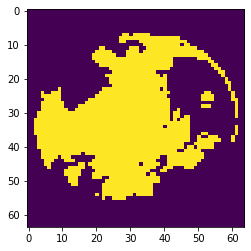

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(d_)
plt.show()

In [ ]:
data_path = os.path.join('64x64', 'train_norm_binary') + '.pkl'

df = pd.read_csv(os.path.join('64x64', 'train') + '.csv', names=range(0,4097))

data = []

y = df[0]
x = np.array(df.drop(labels=[0], axis=1)).reshape(-1, 64, 64)
binarizer = Binarizer(threshold=123)

for i in range(len(y)):
    x[i] = binarizer.transform(x[i])
    print(x[i].shape)
    x[i].reshape(1,64,64)
    data.append((x[i], y[i]))
    if(i % 1000 == 0):
        print(i)
print(len(data))
with open(data_path, 'wb') as f:
    pickle.dump(data, f)

In [ ]:
data_path = os.path.join('64x64', 'test_binary') + '.pkl'

df = pd.read_csv(os.path.join('64x64', 'test') + '.csv', names=range(0,4097))

data = []

y = df[0]
x = np.array(df.drop(labels=[0], axis=1)).reshape(-1, 64, 64)
binarizer = Binarizer(threshold=123)

for i in range(len(y)):
    x[i] = binarizer.transform(x[i])
    x[i].reshape(1,64,64)
    data.append((x[i], y[i]))
    if(i % 1000 == 0):
        print(i)
print(len(data))
with open(data_path, 'wb') as f:
    pickle.dump(data, f)

In [ ]:
data_path = os.path.join('64x64', 'val_binary') + '.pkl'

df = pd.read_csv(os.path.join('64x64', 'val') + '.csv', names=range(0,4097))

data = []

y = df[0]
x = np.array(df.drop(labels=[0], axis=1)).reshape(-1, 64, 64)
binarizer = Binarizer(threshold=123)

for i in range(len(y)):
    x[i] = binarizer.transform(x[i])
    x[i].reshape(1,64,64)
    data.append((x[i], y[i]))
    if(i % 1000 == 0):
        print(i)
print(len(data))
with open(data_path, 'wb') as f:
    pickle.dump(data, f)